# (Optional) Check hardware for available GPU

In this section, I am using tensorflow to check for available GPUs and (if possible) set memory growth across the GPUs

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Library and data import

In [2]:
import pandas as pd                                     # For reading and working with tabular csv data
import tensorflow as tf                                 # General machine learning functionalities
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence             # For creating data generators for training
import numpy as np
import matplotlib.pyplot as plt                         # To visualize model training process
from sklearn.model_selection import train_test_split

import os                                               # For saving models and training results
from datetime import datetime                           # For creating the directory of each training run
import json                                             # For storing training parameters during each run

c:\Users\caomi\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Discovery and Processing

In [3]:
# # Old data, which was split into feature and label files
# feature_csv_path = "data/inputs.csv"
# label_csv_path = "data/outputs.csv"

# # Load features and labels
# features_df = pd.read_csv(feature_csv_path)
# label_df = pd.read_csv(label_csv_path)

data_csv_path = "FIS/data.csv"
data_df = pd.read_csv(data_csv_path)

## Data inspection and discovery

In [4]:
print(f"Dimension of feature dataframe: ",data_df.shape)
data_df.sample(10)

Dimension of feature dataframe:  (10000, 7)


,Load History,Distance to Task,Total Distance Travelled,Robot Type,Task Type,Capability Match?,Suitability
9459,5,13.018436,30.125967,Large,Medium,0,0.000000
3749,3,15.415403,2.196409,Large,Large,1,6.232016
3144,6,20.700096,23.763424,Small,Medium,0,0.000000
5444,1,12.912241,23.568843,Large,Large,1,5.134161
9806,1,23.255780,44.692037,Large,Large,1,2.687295
5428,6,9.516118,15.951095,Medium,Medium,1,4.681734
7916,2,21.277518,3.036369,Medium,Medium,1,5.588596
8538,7,6.922848,9.887687,Large,Small,0,0.000000
2631,2,21.028588,39.822941,Medium,Small,0,0.000000
6789,2,2.943157,11.045518,Medium,Medium,1,6.686399


The capability match feature already reflects the match between robot type and task type, where capability is 1 if robot type == task type. Furthermore, these features are categorical, so they are discarded

In [5]:
feature_df = data_df.drop(columns=['Robot Type', 'Task Type','Suitability'])
INPUT_SHAPE = feature_df.shape[1]

print(f"Dimension of label dataframe: ",feature_df.shape)
feature_df.head(10)

Dimension of label dataframe:  (10000, 4)


,Load History,Distance to Task,Total Distance Travelled,Capability Match?
0,9,20.540772,27.597702,1
1,2,10.080196,38.724002,1
2,8,8.690871,29.982843,0
3,5,9.835623,37.867265,1
4,1,0.416514,13.785328,0
5,6,22.022368,41.682977,1
6,3,21.526918,46.457266,1
7,1,10.323034,36.546152,1
8,3,9.924901,20.932862,1
9,4,4.435074,38.906418,1


In [6]:
label_df = pd.DataFrame(data_df['Suitability'])

print(f"Dimension of label dataframe: ",label_df.shape)
label_df.head(10)

Dimension of label dataframe:  (10000, 1)


,Suitability
0,2.094455
1,5.078582
2,0.000000
3,3.919463
4,0.000000
5,1.533857
6,2.571079
7,5.734623
8,5.007826
9,5.200229


## Convert dataframe to numpy arrays

In [7]:
features_array = feature_df.to_numpy()
label_array = label_df.to_numpy()

## Train-Test Split

In [8]:
# Split the training data to test set and (train+validation) set
TRAIN_TEST_SPLIT = 0.2
X_train, X_test, y_train, y_test = train_test_split(features_array,
                                                    label_array,
                                                    test_size=TRAIN_TEST_SPLIT,
                                                    random_state=12)

TRAIN_VAL_SPLIT = 0.2
# Split the (train + validation) set to train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=TRAIN_VAL_SPLIT,
                                                  random_state=12)

In [9]:
print(f"There are {X_train.shape[0]} samples in the train set\n"
      f"There are {X_val.shape[0]} samples in the validation set\n"
      f"There are {X_test.shape[0]} samples in the test set")

There are 6400 samples in the train set
There are 1600 samples in the validation set
There are 2000 samples in the test set


In [10]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
BATCH_SIZE = 32

# These generator objects will generate BATCH_SIZE samples at a time from the specified nparray
train_gen = DataGenerator(X_train,y_train,BATCH_SIZE)
val_gen = DataGenerator(X_val,y_val,BATCH_SIZE)
test_gen = DataGenerator(X_test,y_test,BATCH_SIZE)

# Create model directory
This directory is associated with the current timestamp. When running though model training, evaluation, and prediction, the following informations are saved into the directory
* Training parameters and training results inside a json file
* Loss curves and metrics curve pictures
* Test prediction vs Actual test label scatter plot
* Histogram of prediction error
* The h5 model

In [11]:
# Generate a timestamped directory for the training run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"Result logs/run_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

# Model Construction

In [12]:
LOSS_FN = 'mse'
METRICS = ['mae',keras.metrics.RootMeanSquaredError()]

def build_model(layer_widths, input_shape, activation='relu', learning_rate=0.001):
    """
    Creates a Keras Sequential model based on the specified architecture.

    Args:
        layer_widths (list): A list where each element is the number of nodes in a layer.
        input_shape (tuple): Shape of the input data (e.g., (num_features,)).
        activation (str): Activation function to use in the hidden layers.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model (Sequential): A compiled Keras Sequential model.
    """
    model = keras.Sequential()

    # Add additional hidden layers based on layer_widths
    for i,width in enumerate(layer_widths):
        if i==0: 
            model.add(layers.Dense(width, activation=activation, input_shape=input_shape))
        else: 
            model.add(layers.Dense(width, activation=activation))
        model.add(layers.BatchNormalization())

    # Add the output layer (no activation for regression)
    model.add(layers.Dense(1,name = "Output_layer"))

    # Compile the model with a regression-friendly loss function
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss=LOSS_FN, 
                  metrics=METRICS)
    
    return model

LAYER_WIDTHS = [64,32,16,1]
LEARNING_RATE = 0.0001
EPOCH = 100
tf.keras.backend.clear_session()
model = build_model(layer_widths = LAYER_WIDTHS,
                    input_shape= (INPUT_SHAPE,),
                    learning_rate=LEARNING_RATE)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_2 (Batc  (None, 16)               6

# Model Training and Training Visualization

In [13]:
history = model.fit(train_gen,
                    batch_size=BATCH_SIZE,
                    validation_data=val_gen,
                    epochs = EPOCH)

Epoch 1/100
200/200 [==============================] - 2s 6ms/step - loss: 14.6624 - mae: 3.2355 - root_mean_squared_error: 3.8291 - val_loss: 13.8296 - val_mae: 3.2303 - val_root_mean_squared_error: 3.7188
Epoch 2/100
200/200 [==============================] - 1s 5ms/step - loss: 13.2344 - mae: 3.1466 - root_mean_squared_error: 3.6379 - val_loss: 11.8395 - val_mae: 2.9712 - val_root_mean_squared_error: 3.4409
Epoch 3/100
200/200 [==============================] - 1s 5ms/step - loss: 11.6573 - mae: 3.0107 - root_mean_squared_error: 3.4143 - val_loss: 9.6926 - val_mae: 2.5983 - val_root_mean_squared_error: 3.1133
Epoch 4/100
200/200 [==============================] - 2s 11ms/step - loss: 10.3856 - mae: 2.8614 - root_mean_squared_error: 3.2227 - val_loss: 9.5281 - val_mae: 2.6881 - val_root_mean_squared_error: 3.0868
Epoch 5/100
200/200 [==============================] - 3s 15ms/step - loss: 9.6958 - mae: 2.7791 - root_mean_squared_error: 3.1138 - val_loss: 9.3805 - val_mae: 2.7387 - val

In [14]:
training_params = {
    "learning_rate": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCH,
    "structure": LAYER_WIDTHS,
}

# Store the final training results
training_results = {}

for i in history.history.keys():
    training_results[i] = history.history[i][-1]

# Save the training parameters and training results in the directory
params_path = os.path.join(output_dir, "training_params.json")
with open(params_path, "w") as f:
    json.dump({"parameters": training_params, "results": training_results}, f, indent=4)
print(f"Training parameters saved at {params_path}")

Training parameters saved at Result logs/run_20241124_132200\training_params.json


In [15]:
def plot_performance(history, learning_rate=None, batch_size=None, finetune_epochs=None, save_dir=None):
    # Determine whether history is keras history or a dictionary to appropriately extract the history data
    if isinstance(history, keras.callbacks.History):
        history_data = history.history        # Extract the history dictionary
    else:
        history_data = history                # Assume it's already a dictionary

    metric_list = list(history_data.keys())     # Extract the list of history keys
    half_length = len(metric_list) // 2         # The index where the validation metrics start

    metric2txt_dict = {'mae': "Mean Absolute Error",
                       'root_mean_squared_error': "Root Mean Square Error",
                       'loss': 'Loss'}

    plt.figure(figsize=(half_length * 5,5))

    for index, metric in enumerate(metric_list[:half_length]):
        metric_train = metric
        metric_val = metric_list[index+half_length]

        plt.subplot(1,half_length,index+1)
        ylim_acc = [0, max(max(history_data[metric_train]),max(history_data[metric_val]))]
        plt.plot(history_data[metric_train], label = metric_train)
        plt.plot(history_data[metric_val], label = metric_val)
        plt.ylim(ylim_acc)
        # plt.ylabel(metric_train)
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        if learning_rate and batch_size:
            plt.title(f'{metric2txt_dict[metric_train]} \n lr = {learning_rate}, batch size = {batch_size}')
        else: plt.title(f'{metric2txt_dict[metric_train]}')

        plt.grid(which='major', color='black', linestyle='--', linewidth=0.5)

        # Enable the minor grid
        plt.minorticks_on()  # Turn on the minor ticks
        plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)

    # Save the plots if a directory is provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        plot_path = os.path.join(save_dir, "performance_plot.png")
        plt.savefig(plot_path)
        print(f"Performance plot saved at {plot_path}")

Performance plot saved at Result logs/run_20241124_132200\performance_plot.png


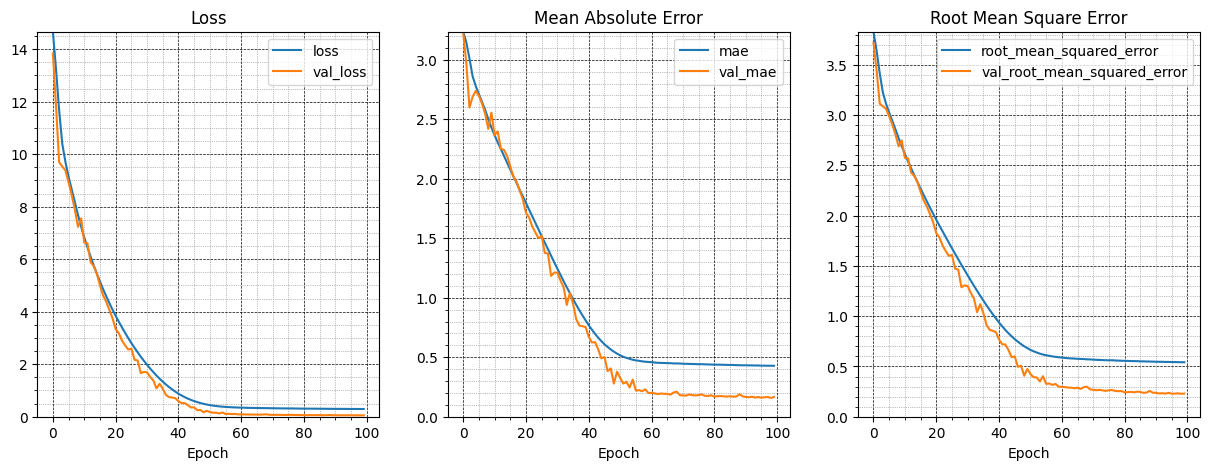

In [16]:
plot_performance(history,save_dir = output_dir)

# Model Prediction

63/63 [==============================] - 1s 8ms/step - loss: 0.0549 - mae: 0.1626 - root_mean_squared_error: 0.2344

Model testing performance 
Test loss 	 0.055
Test MAE 	 0.163
Test RMSE 	 0.234
63/63 [==============================] - 0s 3ms/step
Test vs prediction scatter plot saved at Result logs/run_20241124_132200\test_prediction.png


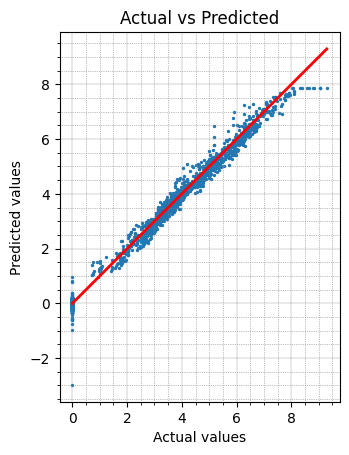

Historgram of prediction error saved at Result logs/run_20241124_132200\error_history.png


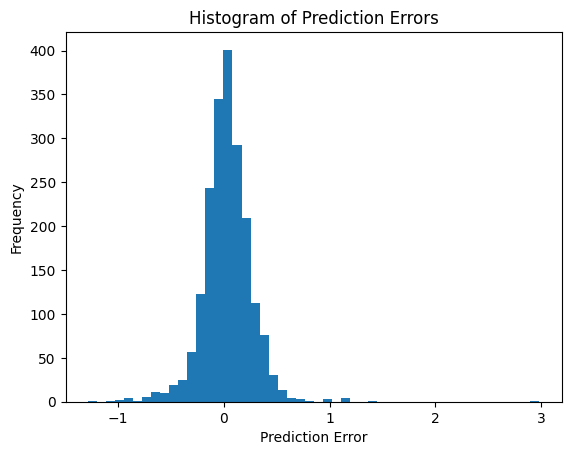

In [17]:
test_loss, test_mae, test_rmse = model.evaluate(test_gen)

print(f"\nModel testing performance \n"
      f"Test loss \t {test_loss:.3f}\n"
      f"Test MAE \t {test_mae:.3f}\n"
      f"Test RMSE \t {test_rmse:.3f}")

y_pred = model.predict(X_test)


# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred,s=2)

# Line showing perfect prediction (if predicted = actual)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted')

plt.grid(which='major', color='gray', linestyle='-', linewidth=0.25)
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
plt.minorticks_on()

test_prediction_plot_path = os.path.join(output_dir, "test_prediction.png")
plt.savefig(test_prediction_plot_path)
print(f"Test vs prediction scatter plot saved at {test_prediction_plot_path}")
plt.show()


# Histogram of prediction error
errors = y_test - y_pred
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')

error_history_path = os.path.join(output_dir, "error_history.png")
plt.savefig(error_history_path)
print(f"Historgram of prediction error saved at {error_history_path}")
plt.show()

# Save the Model

In [18]:
# Define the model directory with the timestamp
model_directory = f"Result logs/run_{timestamp}/model.h5"

# Save the model in HDF5 format
model.save(model_directory)
print(f"Model saved as {model_directory}")

Model saved as Result logs/run_20241124_132200/model.h5


# Load the Model

In this section, I will load the saved .h5 model and retest it on the testset. The regression results should be identical to the results in the Model Prediction section

In [19]:
from tensorflow.keras.models import load_model


loaded_model = load_model('model/model.h5')

In [20]:
y_loaded_pred = loaded_model.predict(X_test)

63/63 [==============================] - 0s 4ms/step


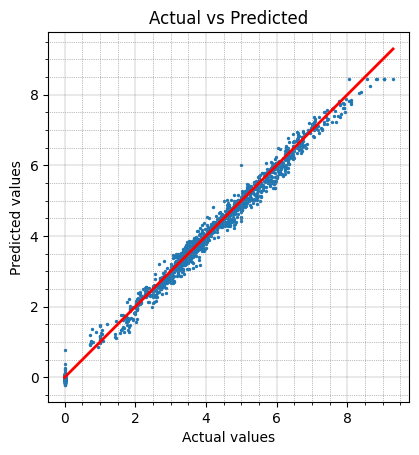

In [21]:
# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_loaded_pred,s=2)

# Line showing perfect prediction (if predicted = actual)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted')

plt.grid(which='major', color='gray', linestyle='-', linewidth=0.25)
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
plt.minorticks_on()

plt.show()

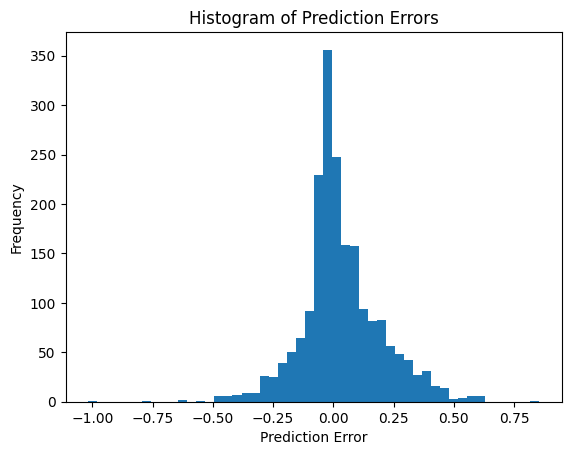

In [22]:
errors = y_test - y_loaded_pred
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()